In [89]:
import pandas as pd

df = pd.read_csv('crude-oil-price.csv')
print(df.head())
print(df.columns)
print(df.info())

                        date  price  percentChange  change
0  1983-03-01 00:00:00+00:00  29.27            NaN     NaN
1  1983-04-01 00:00:00+00:00  30.63          4.646    1.36
2  1983-05-01 00:00:00+00:00  30.25         -1.241   -0.38
3  1983-06-01 00:00:00+00:00  31.38          3.736    1.13
4  1983-07-01 00:00:00+00:00  32.00          1.976    0.62
Index(['date', 'price', 'percentChange', 'change'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           508 non-null    object 
 1   price          508 non-null    float64
 2   percentChange  507 non-null    float64
 3   change         507 non-null    float64
dtypes: float64(3), object(1)
memory usage: 16.0+ KB
None


In [90]:
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)  # Remove timezone
conflict_months = ['2024-04', '2024-10', '2025-04', '2025-06']
df['Conflict'] = df['date'].dt.to_period('M').astype(str).isin(conflict_months).astype(int)

Cleans down the date from 1983-03-01 00:00:00+00:00 to just 1983-03
Adds conflict indicator; in 2024 april there was tensions between iran-israel

In [91]:
df['TargetPriceSurge'] = (df['percentChange'].shift(-1) > 3).astype(int)

In [92]:
import matplotlib.pyplot as plt

In [93]:
def classify_price_trend(pct_change):
    if pct_change < -3:
        return 0  # significant drop
    elif pct_change > 3:
        return 2  # significant rise
    else:
        return 1  # stable

df['TargetTrend'] = df['percentChange'].shift(-1).apply(classify_price_trend)

In [94]:
df = df.dropna()
y = df['TargetTrend']
X = df[['price', 'change', 'Conflict']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions, target_names=[
    "Drop >3%", "Stable", "Rise >3%"
]))

              precision    recall  f1-score   support

    Drop >3%       0.45      0.41      0.43        34
      Stable       0.33      0.29      0.31        24
    Rise >3%       0.44      0.50      0.47        44

    accuracy                           0.42       102
   macro avg       0.41      0.40      0.40       102
weighted avg       0.42      0.42      0.42       102



In [96]:
latest_row = df.iloc[[-1]]
latest_features = latest_row[['price', 'change', 'Conflict']]
pred = model.predict(latest_features)[0]

labels = {0: "📉 drop by more than 3%", 1: "〰️ remain relatively stable", 2: "📈 rise by more than 3%"}
print("🛢️ Prediction for next month ({}):".format(latest_row['date'].values[0]))
print("Price will likely", labels[pred])


🛢️ Prediction for next month (2025-06-01T00:00:00.000000000):
Price will likely 📈 rise by more than 3%


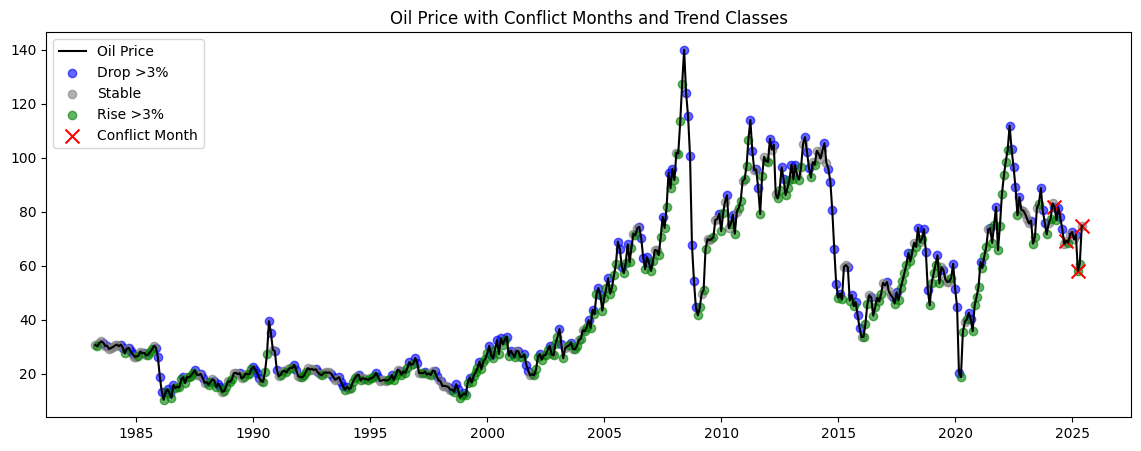

In [97]:
# Plot with predicted trend classes
trend_colors = {0: 'blue', 1: 'gray', 2: 'green'}  # Drop, Stable, Rise
trend_labels = {0: 'Drop >3%', 1: 'Stable', 2: 'Rise >3%'}

plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['price'], label='Oil Price', color='black')

# Plot trend prediction markers
for trend_class in [0, 1, 2]:
    subset = df[df['TargetTrend'] == trend_class]
    plt.scatter(subset['date'], subset['price'], 
                label=trend_labels[trend_class], 
                color=trend_colors[trend_class], 
                alpha=0.6)

# Highlight conflict periods
plt.scatter(df[df['Conflict'] == 1]['date'], df[df['Conflict'] == 1]['price'],
            color='red', label='Conflict Month', marker='x', s=100)

plt.title('Oil Price with Conflict Months and Trend Classes')
plt.legend()
plt.show()



Lets build the what the graph would look like next month

In [98]:
trend_pct_map = {
    0: -5,   # Drop >3% → assume -5%
    1: 0,    # Stable → assume 0%
    2: 5     # Rise >3% → assume +5%
}

Latest known price prediction

In [99]:
latest_row = df.iloc[[-1]]
latest_features = latest_row[['price', 'change', 'Conflict']]
pred = model.predict(latest_features)[0]

latest_date = latest_row['date'].values[0]
latest_price = latest_row['price'].values[0]
predicted_pct_change = trend_pct_map[pred]
predicted_price = latest_price * (1 + predicted_pct_change / 100)

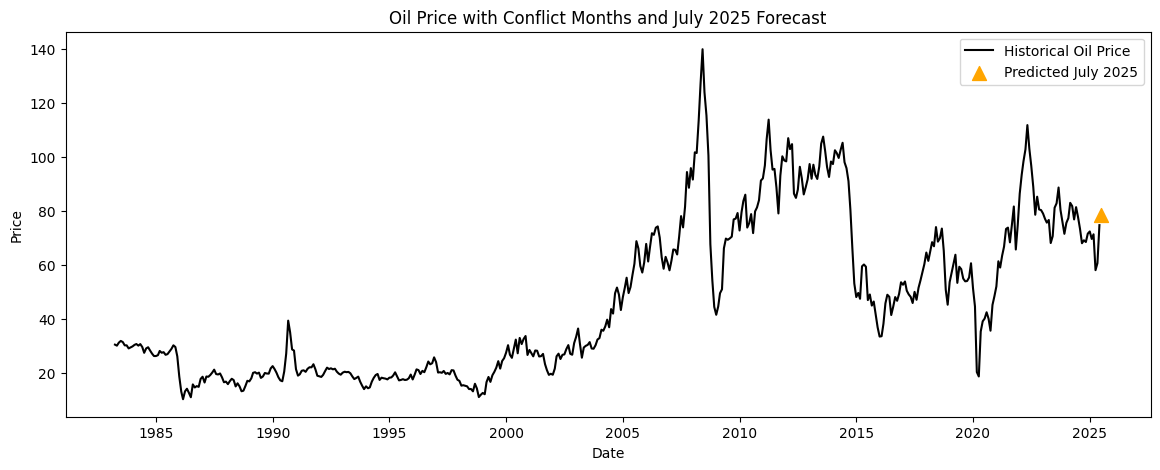

🛢️ Forecasted price for July 2025: $78.62 (+5%)


In [100]:
import datetime

# Add July 2025 prediction point
predicted_date = latest_row['date'].iloc[0] + pd.DateOffset(months=1)

plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['price'], label='Historical Oil Price', color='black')

# Highlight predicted point
plt.scatter(predicted_date, predicted_price, color='orange', s=100, marker='^', label='Predicted July 2025')

plt.title('Oil Price with Conflict Months and July 2025 Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(f"🛢️ Forecasted price for July 2025: ${predicted_price:.2f} ({predicted_pct_change:+}%)")

No conflict markers to just show where prices will be at